In [1]:
from pc_skeletor import LBC, laplacian
import matplotlib.pyplot as plt 
import numpy as np
import pyvista as pv
import open3d as o3d
import os
import mistree as mist
import cloudComPy as cc
import networkx as nx
import pyvista as pv
import xarray as xr

import time
from helpers.rotation import RotateFromTo
from helpers.utils import reorder_points, reorder_MST
from tqdm import tqdm as tqdm
from helpers.descriptors import Section

from yaml import load
from yaml.loader import Loader

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# convenience function to downsample a numpy array spatially using the cloudcompy implementation 
def spatially_downsample(pointcloud: np.ndarray, min_distance: float = 0.1):
    cloud = cc.ccPointCloud()
    cloud.coordsFromNPArray_copy(pointcloud)

    ref = cc.CloudSamplingTools.resampleCloudSpatially(cloud, minDistance= min_distance)
    (downsampled, res) = cloud.partialClone(ref)

    return downsampled.toNpArrayCopy()
    

In [3]:
# convenience function to go from numpy to o3d needed by LBC
def array_to_o3d(pointcloud: np.ndarray):
    cloud = o3d.geometry.PointCloud()
    cloud.points = o3d.cpu.pybind.utility.Vector3dVector(pointcloud)

    return cloud

In [4]:
# define the paths to pointclouds
root = "F:/ScanLeica/from_pointcloud_to_mesh/real_data/10_Lauiloch/"
SCAN_NAME = "Seengang"

caveName = "17_Hoelloch"
SCAN = 2
root = f"../../real_data/{caveName}"

PROCESSING_FILEPATH = os.path.join(root, "params.yaml")
p = load(open(PROCESSING_FILEPATH), Loader)

SCAN_NAME = p['paths']['scanNames'][SCAN]
GLOBAL_SHIFT = p["alignment"]["globalShift"]

fp = os.path.normpath(os.path.join(root, f"output/{SCAN_NAME}", f"{SCAN_NAME}_georef_subsampled.ply"))
# read the data
pcd = o3d.io.read_point_cloud(fp)


In [5]:
# subsample to 15 cm minimum distance
downsampled = spatially_downsample(np.asarray(pcd.points), min_distance=0.15)
# convert to open3d object-
downsampled_pcd = array_to_o3d(downsampled + np.array(GLOBAL_SHIFT))

In [6]:
# set up the Laplacianbased contraction algorithm 
lbc = LBC(point_cloud=downsampled_pcd, down_sample= 0.01, termination_ratio= 0.001)

In [7]:
# extract the skeleton (this step takes a little while) 
lbc.extract_skeleton()

2024-04-18 10:16:16,075 - PCD #points: 383807
Current volume ratio 0.0018419667582127092. Contraction weights 2048.0. Attraction weights 1023.8803511793606. Progress2024-04-18 10:38:56,393 - Contraction is Done.


Contraction is Done.


Current volume ratio 0.0018419667582127092. Contraction weights 2048.0. Attraction weights 1023.8803511793606. Progress


array([[ 255.79303741, -123.04428244,   85.90996664],
       [ 442.66391316, -192.28509551,  139.44006288],
       [ 296.88256534, -141.55525927,   92.52813534],
       ...,
       [ 207.68379706, -113.1046315 ,   76.47791235],
       [ 215.20302857, -114.88990875,   78.19902799],
       [ 231.92626992, -117.61947864,   81.86360538]])

In [8]:
# extract the first topology from LBC (this is usually rough and not very useful.)
lbc.extract_topology()

LineSet with 4560 lines.

In [9]:
# convert the o3d representation to numpy. 
coords = np.asarray(lbc.contracted_point_cloud.points)
std = coords.std(axis= 0)
mean = coords.mean(axis= 0)

coords 

array([[ 255.79303741, -123.04428244,   85.90996664],
       [ 442.66391316, -192.28509551,  139.44006288],
       [ 296.88256534, -141.55525927,   92.52813534],
       ...,
       [ 207.68379706, -113.1046315 ,   76.47791235],
       [ 215.20302857, -114.88990875,   78.19902799],
       [ 231.92626992, -117.61947864,   81.86360538]])

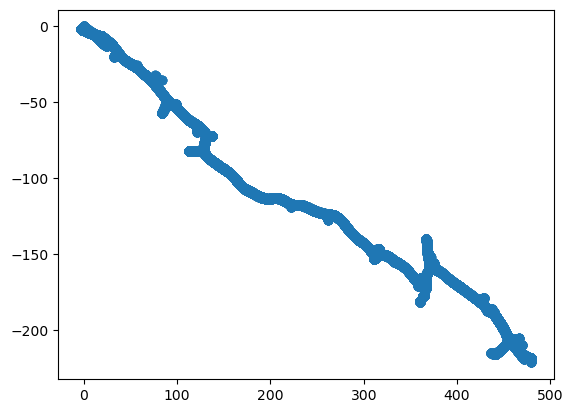

In [10]:
plt.scatter(coords[:, 0], coords[:, 1])

In [11]:
# use the convenience function to downsample to every half-meter. 
downsampled_coords = spatially_downsample(coords, min_distance=0.5)

In [12]:
# use minimum spanning tree library to reconstruct the topology of the downsampled skeleton
mst = mist.GetMST(x=downsampled_coords[:, 0], y=downsampled_coords[:, 1], z=downsampled_coords[:, 2])
degree, edge_length, branch_length, branch_shape, edge_index, branch_index = mst.get_stats(include_index=True, k_neighbours= 15)

(array([78., 11.,  4.,  2.,  1.,  1.,  0.,  0.,  0.,  1.]),
 array([  1.03592668,  11.45725625,  21.87858583,  32.2999154 ,
         42.72124498,  53.14257455,  63.56390412,  73.9852337 ,
         84.40656327,  94.82789285, 105.24922242]),
 <BarContainer object of 10 artists>)

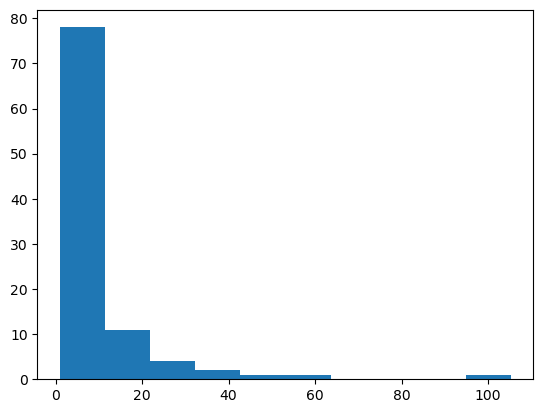

In [13]:
# check the various branch lengths
plt.hist(branch_length)

In [14]:
# create networkx object for the minimum spanning tree graph
mst_graph = nx.Graph(edge_index.T.tolist())
# set up the positions of the minimum spanning tree graph
for idx in mst_graph.nodes():
    mst_graph.nodes[idx]['pos'] = downsampled_coords[idx].T

In [15]:
# filter by branch length. 
long_enough = np.asarray(branch_length) > 7
# how many branches meet the length criterion
n = int(np.sum(long_enough))

long_branches = []

for c, is_long_enough in enumerate(long_enough):
   
    if is_long_enough:
        edges = branch_index[c]
        branch = edge_index[:, edges]
    
        branch_graph = nx.Graph(branch.T.tolist())
        long_branches += branch.T.tolist()
        
G = nx.Graph(long_branches)

for idx in G.nodes():
    G.nodes[idx]['pos'] = mst_graph.nodes[idx]["pos"]
        

In [16]:
# find the connected components and the centreline and its vectors to an array.

n = len(G.nodes)
centreline = np.zeros((n, 8))    
k = 0
for c, branch in enumerate(nx.connected_components(G)):
    for node_idx in branch: 
        if G.degree(node_idx) == 2:
            prev, next = [elem for elem in G.neighbors(node_idx)]
            vec = G.nodes[next]["pos"] - G.nodes[prev]["pos"]
        else:
            next = [elem for elem in G.neighbors(node_idx)][0]
            vec = G.nodes[next]["pos"] - G.nodes[node_idx]["pos"]
    
        G.nodes[node_idx]["vec"] = vec
        # write the node 
        centreline[k, 0] = c
        centreline[k, 1] = node_idx
        centreline[k, [2,3,4]] = G.nodes[node_idx]["pos"]
        centreline[k, [5,6,7]] = G.nodes[node_idx]["vec"]
        k+=1

centreline_fp = os.path.normpath(os.path.join(root, "process/centrelines", f"{SCAN_NAME}_centreline3d.txt"))
print(centreline_fp)
np.savetxt(centreline_fp, centreline)

..\..\real_data\17_Hoelloch\process\centrelines\Riesengang_centreline3d.txt


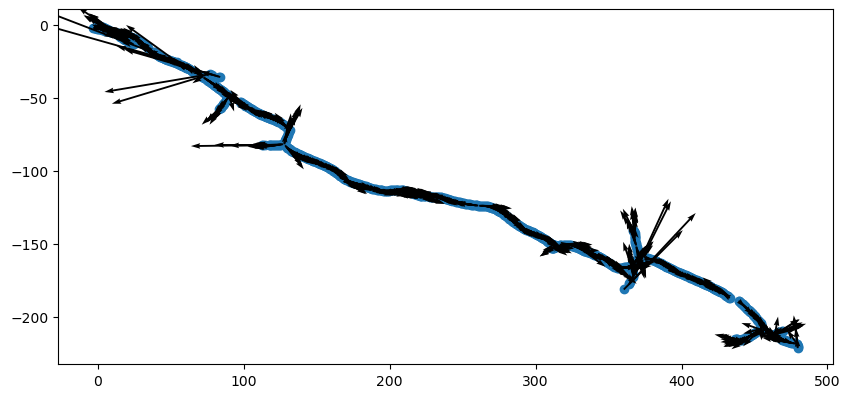

In [17]:
fig, ax = plt.subplots(figsize = (10,10))

ax.quiver(centreline[:,2], centreline[:,3], centreline[:,5], centreline[:,6], scale=45)
ax.scatter(centreline[:, 2], centreline[:, 3], zorder = -10)
ax.set_aspect("equal")

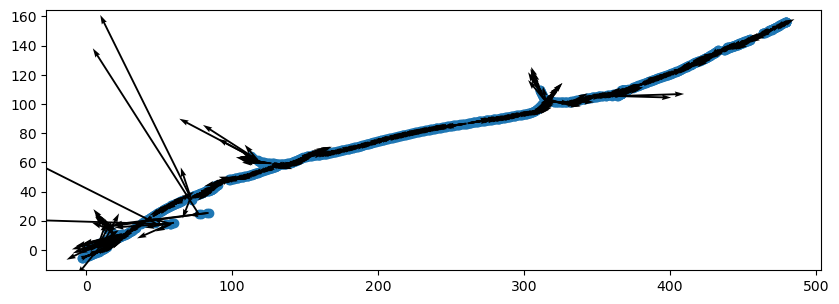

In [18]:
fig, ax = plt.subplots(figsize = (10,10))

ax.quiver(centreline[:,2], centreline[:,4], centreline[:,5], centreline[:,7], scale=45)
ax.scatter(centreline[:, 2], centreline[:, 4], zorder = -10)
ax.set_aspect("equal")

In [19]:
# project the section-normal vectors onto horizontal plane. 
horiz_dip_dir = np.asarray((centreline[:, 4], centreline[:, 5], 0 * centreline[:, 6])).T

In [20]:
mesh_fp =os.path.normpath(os.path.join(root, f"output/{SCAN_NAME}", f"{SCAN_NAME}_5cm_clean.stl"))

mesh = pv.read(mesh_fp).extract_surface().triangulate()

d1 = np.array([0, 1, 0])


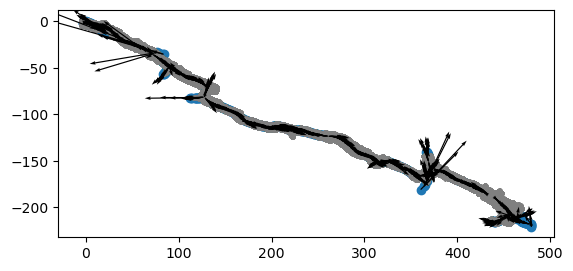

In [21]:
fig, ax = plt.subplots()
pcd = mesh.cast_to_pointset().points 
ax.scatter(pcd[:, 0], pcd[:, 1], color = "grey", s=2)

ax.quiver(centreline[:,2], centreline[:,3], centreline[:,5], centreline[:,6], scale=45)
ax.scatter(centreline[:, 2], centreline[:, 3], zorder = -10)
ax.set_aspect("equal")
plt.show()

In [22]:
n = len(centreline)

In [23]:
def calculate_intersections(start_index, end_index):
    for c in tqdm(range(start_index, end_index), total=end_index - start_index):

        orig = centreline[c, [2,3,4]]
        vec = centreline[c, [4,5,6]]
        vec_horiz = horiz_dip_dir[c]
        
        node_idx = int(centreline[c, 1])
        branch_idx = int(centreline[c, 0])
        
        plane = pv.Plane(orig, vec , 30, 30, 100, 100).extract_surface().triangulate()
        inter, _, _ = mesh.intersection(plane, split_first = False, split_second = False)
        
        R1 =  RotateFromTo(vec, vec_horiz, verbose=False)
        pp = inter.points - np.mean(plane.points, axis=0)
        pp_vertical = R1 @ pp.T
        R2 = RotateFromTo(vec_horiz, d1)
        pp_rotated = R2 @ pp_vertical
        
        unordered = pp_rotated.T
       
        verbose = False
        try:
            # reorder the intersection points 

            assert unordered.shape[0] > 25

            OUT_FP = os.path.normpath(os.path.join(root, "process/sections_as_polylines", f"{SCAN_NAME}_{node_idx}_unordered.txt"))
            np.savetxt(OUT_FP, unordered)
            ordered = reorder_MST(unordered)
            
            # recentre to barycentre
            ordered = ordered - np.mean(ordered, axis = 0)
        
            ds = xr.DataArray(ordered[:, [0, 2]], dims=("point", "coords_xz"))
            ds.attrs["position"] = orig
            ds.attrs["normal"] = vec
            ds.attrs["node_index"] = node_idx
            ds.attrs["branch_index"] = branch_idx
            OUT_FP = os.path.normpath(os.path.join(root, "process/sections_as_polylines", f"{SCAN_NAME}_{node_idx}.nc"))
            ds.to_netcdf(OUT_FP)
        
        except (IndexError, PermissionError, AssertionError):
            if verbose == True:
                print("empty intersection, I'll skip this. ")
            pass

In [24]:
s = time.time()
calculate_intersections(892, n)
e = time.time()
print(f"time elapsed: {e-s}s")

100%|██████████████████████████████████████████████████████████████████████████████| 106/106 [1:32:40<00:00, 52.45s/it]

time elapsed: 5560.22102189064s
